<a href="https://colab.research.google.com/github/nicholasproietti/LGM/blob/main/LC_FFT_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP trained on Filtered Lightcruves

---



In this notebook, we explored on training a Multi-Layered Perceptron only on filtered light curves to see if sole light curve data is enough to predict the radius of an exoplanet

### Install the lightkurve libary and import the necessary packages

In [14]:
!pip install lightkurve

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightkurve as lk
import scipy
from scipy.fft import fft, fftfreq
from scipy import signal
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from scipy.fft import fft, ifft
from sklearn import neural_network
from sklearn.metrics import r2_score

The KOI data is under the link ```https://raw.githubusercontent.com/nicholasproietti/LGM/main/data/KOI.csv```


In [213]:
url = "https://raw.githubusercontent.com/nicholasproietti/LGM/main/data/KOI.csv"

KOI = pd.read_csv(url)
KOI.drop(KOI.columns[0], axis=1, inplace=True)
#KOI = KOI.drop(KOI[KOI['koi_disposition']!='CONFIRMED'].index)
KOI = KOI.drop(KOI[KOI['koi_disposition']=='FALSE POSITIVE'].index)
KOI = KOI[KOI['koi_prad'].notna()]
KOI.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,0,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,0,...,-0.021,-0.038,0.00070,0.00060,-0.025,-0.034,0.042,0.002,-0.027,0.027
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
5,10872983,K00756.01,Kepler-228 d,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,-0.120,0.140,0.00004,NaN,0.040,-0.070,0.080,-0.020,-0.080,0.080


## Examining the Light curves

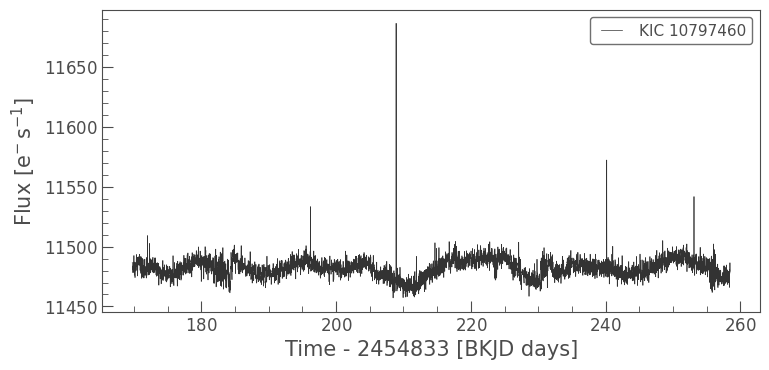

In [214]:
search_result_q2 = lk.search_lightcurve('KIC ' + str(KOI['kepid'][0]), author='Kepler', quarter=2)
lc = search_result_q2.download()
lc = lc.fill_gaps()
lc.plot()

Power Spectrum of a sample light curve

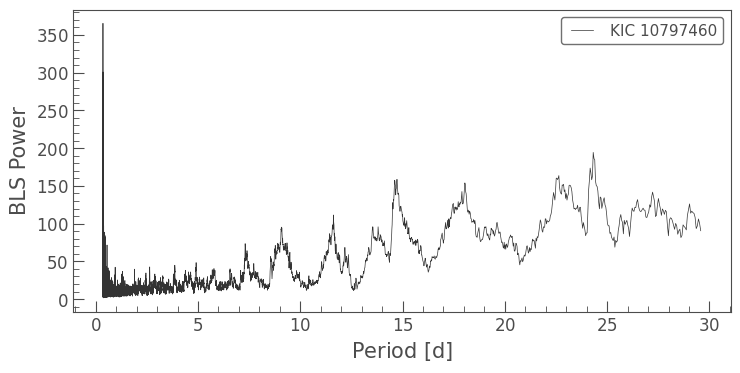

In [215]:
f = lc['flux'].value
t = lc['time'].value
periodogram = lc.to_periodogram(method='bls')
periodogram.plot()

For each light curve its Fourier Transform is computed. As stellar activity is the dominant part of the light curve initial frequencies in the Fourier transform can be set to zero. Then we compute the inverse fourier transform to get the filtered light curve

Text(0, 0.5, 'Flux')

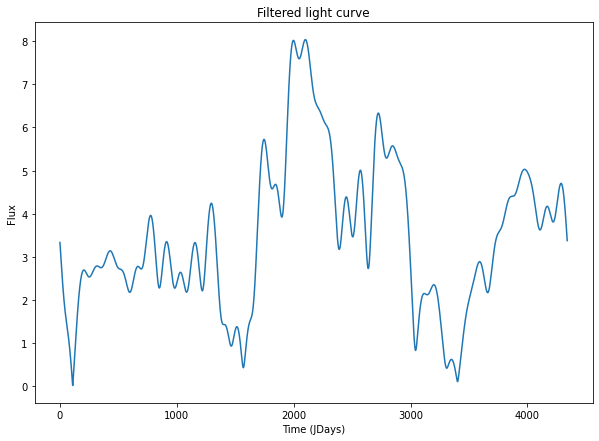

In [216]:
s = fft(f)
s[:4300] = 0
f_cleared = np.abs(ifft(s))
plt.plot(f_cleared)
plt.title('Filtered light curve')
plt.xlabel('Time (JDays)')
plt.ylabel('Flux')

## Downloading and filtering lightcurves

Performing the above steps for all the light curves and storing them in the flux array

In [217]:
outlier_size = 41820
outlier_size_threshold = 4075
flux = np.empty([4075,])
time = np.empty([4075,])
download_failed_index = []
radius = []
for index, rad in zip(KOI.T, KOI['koi_prad']):
  try:
    search_result_q2 = lk.search_lightcurve('KIC ' + str(KOI.iloc[index]['kepid']), author='Kepler', quarter=2)
    lc = search_result_q2.download()
    lc = lc.fill_gaps(method='gaussian_noise')
    flux_small = lc['flux'].value
    time_small = lc['time'].value
    y = np.abs(fft(flux_small))
    y[:4300] = 0
    f_cleared = np.abs(ifft(y))
    #periodogram = lc.to_periodogram(method='bls')
    #power = periodogram.power.to_value()
    #period = periodogram.period.to_value()
    if f_cleared.size > outlier_size_threshold:
      f_cleared = f_cleared[:outlier_size_threshold]
      time_small = time_small[:outlier_size_threshold]

    flux = np.vstack((flux, f_cleared))
    time = np.vstack((time, time_small))
    radius.append(rad)
  except:
    download_failed_index.append(index)
flux = flux[1:]
time = time[1:]

/usr/local/lib/python3.8/dist-packages/lightkurve/search.py:407: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/lightkurve/search.py:407: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/lightkurve/search.py:402: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/lightkurve/search.py:407: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sect

## Preprocessing data for the model

In [218]:
X, y = flux, np.array(radius)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Scaling the flux data

In [219]:
for i in range(len(X_train)):
  X_mean = np.mean(X_train[i])
  X_std = np.std(X_train[i])
  X_train_man_std = (X_train[i] - X_mean) / X_std
  X_train[i] = X_train_man_std

for i in range(len(X_test)):
  X_mean = np.mean(X_test[i])
  X_std = np.std(X_test[i])
  X_test_man_std = (X_test[i] - X_mean) / X_std
  X_test[i] = X_test_man_std

### Normalizing the flux data

In [220]:
for i in range(len(X_train)):
  X_max = np.max(X_train[i])
  X_min = np.min(X_train[i])
  X_train_man_norm = (X_train[i] - X_min) / (X_max - X_min)
  X_train[i] = X_train_man_norm

for i in range(len(X_test)):
  X_max = np.max(X_test[i])
  X_min = np.min(X_test[i])
  X_test_man_norm = (X_test[i] - X_min) / (X_max - X_min)
  X_test[i] = X_test_man_norm

### Validation split

In [221]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

## Building and training the MLP

In [222]:
mlp = neural_network.MLPRegressor(hidden_layer_sizes=(100, 20), activation="relu",
                 solver='adam', alpha=0.0001,
                 batch_size='auto', learning_rate="constant",
                 learning_rate_init=0.001,
                 power_t=0.5, max_iter=1000,tol=1e-4)

mlp.fit(X_train, y_train)
r = mlp.score(X_train, y_train)
y_predict = mlp.predict(X_test)  

Let's define two functions:

```test_validate1()``` will plot the percent error between the predicted exoplanet radius from the MLP regressor and the known radius from the KOI table for every exoplanet in the validation set.

```test_validate2()``` will plot the same set as ```test_validate1()``` with a different representation. The predicted and known exoplanet radius values will be plotted.

In [236]:
def test_validate1(x_test, y_test, y_predict, regressor, set_name):
    x = range(len(y_test))
    per_error = [abs(i-j)/i*100 if i != 0 else None for i,j in zip(y_test,y_predict)]
    plt.plot(x, per_error, "bo", markersize=6, zorder=2)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=3, label="0% error")
    plt.legend(loc="upper left", prop={'size': 14})
    plt.xlabel("Exoplanet Sample Index", fontsize = 14)
    plt.ylabel("Exoplanet Radius Percent Error (%)", fontsize = 14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tick_params(axis='both', which='minor', labelsize=14)
    plt.axis([0, len(per_error), -10, 100])
    plt.title("Accuracy of MLPRegressor Exoplanet Radii Predictions (" + set_name + ')', fontsize = 14)
    plt.show()

def test_validate2(x_test, y_test, y_predict, regressor, set_name):
    x = range(len(y_test))
    plt.plot(x, y_test, "ro", markersize=5, zorder=3, label=u"known")
    plt.plot(x, y_predict, "bo", markersize=8, zorder=2, label=u"R2 Score, =%.3f" % r2_score(y_test, y_predict))
    plt.legend(loc="lower left", prop={'size': 14})
    plt.xlabel("Exoplanet Sample Index", fontsize = 14)
    plt.ylabel("Exoplanet Radius R$_{Earth}$", fontsize = 14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tick_params(axis='both', which='minor', labelsize=14)
    plt.axis([0, len(y_test), -3,20])
    plt.title("Accuracy of MLPRegressor Exoplanet Radii Predictions (" + set_name + ')',fontsize = 14)
    plt.show()

## Loss vs Epoch

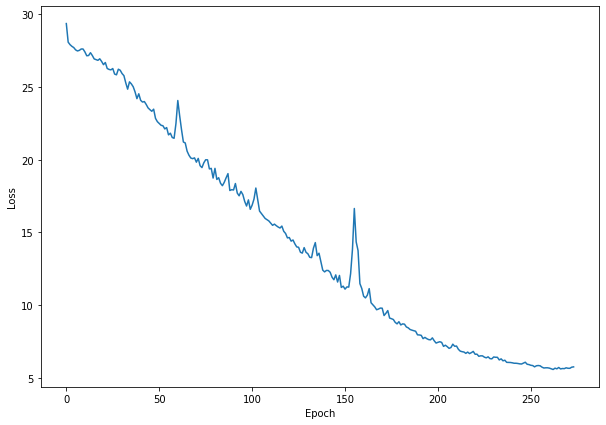

In [230]:
pd.DataFrame(mlp.loss_curve_).plot(xlabel="Epoch", ylabel="Loss", legend=False)

## Accuracy of MLP

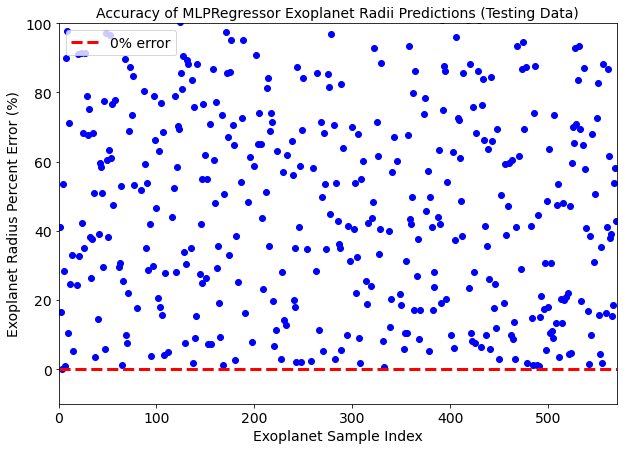

In [231]:
test_validate1(X_test, y_test, y_predict, mlp, 'Testing Data')

## Performance on Testing data

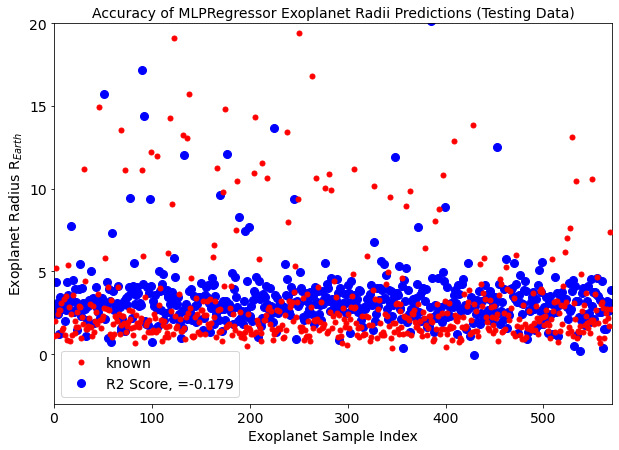

In [237]:
test_validate2(X_test, y_test, y_predict, mlp, 'Testing Data')

## Performance on validation data

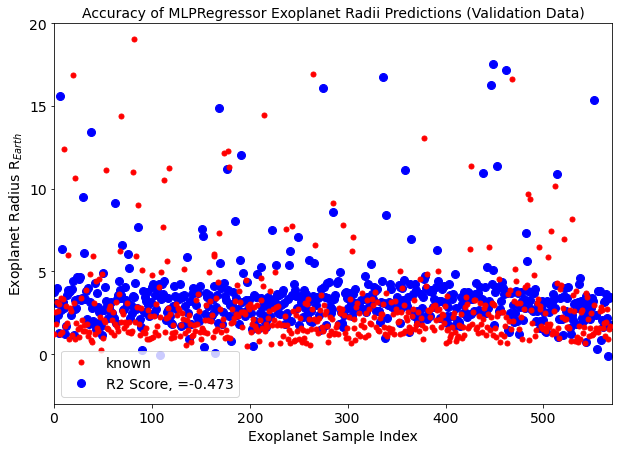

In [238]:
y_val_pred = mlp.predict(X_val)
test_validate2(X_val, y_val, y_val_pred, mlp, 'Validation Data')